In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# assert torch.cuda.is_available()
print(pd.__version__)

1.3.4


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [3]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [4]:
sensor_data = pd.read_csv('sensor.csv', parse_dates=['timestamp'], index_col='timestamp')
display(sensor_data.info())
display(sensor_data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-

None

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [5]:
sensor_data.drop(['Unnamed: 0'], axis=1, inplace=True)
sensor_data.dropna(axis=1, thresh=15000, inplace=True)
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220320 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       210112 non-null  float64
 1   sensor_01       219951 non-null  float64
 2   sensor_02       220301 non-null  float64
 3   sensor_03       220301 non-null  float64
 4   sensor_04       220301 non-null  float64
 5   sensor_05       220301 non-null  float64
 6   sensor_06       215522 non-null  float64
 7   sensor_07       214869 non-null  float64
 8   sensor_08       215213 non-null  float64
 9   sensor_09       215725 non-null  float64
 10  sensor_10       220301 non-null  float64
 11  sensor_11       220301 non-null  float64
 12  sensor_12       220301 non-null  float64
 13  sensor_13       220301 non-null  float64
 14  sensor_14       220299 non-null  float64
 15  sensor_16       220289 non-null  float64
 16  sensor_17       220274

In [6]:
conditions = [(sensor_data['machine_status'] =='NORMAL'), (sensor_data['machine_status'] =='BROKEN'), (sensor_data['machine_status'] =='RECOVERING')]
choices = [1, 0, 0]
sensor_data['Operation'] = np.select(conditions, choices, default=0)
df0 = pd.DataFrame(sensor_data, columns=['Operation','sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09']).dropna()
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214251 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Operation  214251 non-null  int64  
 1   sensor_04  214251 non-null  float64
 2   sensor_06  214251 non-null  float64
 3   sensor_07  214251 non-null  float64
 4   sensor_08  214251 non-null  float64
 5   sensor_09  214251 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 11.4 MB


In [55]:
df_sensor_06 = pd.DataFrame(sensor_data, columns=['Operation','sensor_06']).dropna()

WINDOw_SIZE = 800

def data_generator(window_size = WINDOw_SIZE, df = df_sensor_06, sensor_name: str = "sensor_06"):
    names_columns = [f'J-{i}' for i in range(6, -1, -1)]
    for i in range(0, len(df) - WINDOw_SIZE, 10):
        new_data = df.iloc[i: i + WINDOw_SIZE].describe(percentiles=[.1, .5, .9])[[sensor_name]].transpose().reset_index(drop=True)
        last_week = df.iloc[i + WINDOw_SIZE - 7: i + WINDOw_SIZE][[sensor_name]].transpose().reset_index(drop=True)
        last_week.columns = names_columns
        label = pd.DataFrame([df.iloc[i + WINDOw_SIZE].Operation], columns=['label']).reset_index(drop=True)
        new_data = pd.concat([new_data, last_week, label], axis=1)
        yield new_data

In [8]:
i = 30
df_sensor_06.iloc[i + WINDOw_SIZE - 7: i + WINDOw_SIZE][['sensor_06']].transpose()

timestamp,2018-04-01 13:43:00,2018-04-01 13:44:00,2018-04-01 13:45:00,2018-04-01 13:46:00,2018-04-01 13:47:00,2018-04-01 13:48:00,2018-04-01 13:49:00
sensor_06,13.41869,13.34635,13.28848,13.41869,13.38976,13.30295,13.31742


In [9]:
pd.DataFrame([df_sensor_06.iloc[i + WINDOw_SIZE].Operation], columns=['label'])

,label
0,1.0


In [10]:
df_data_agg = pd.concat(data_generator(), axis=0)
print('======== Concatenation finished ==========')
df_data_agg = df_data_agg.reset_index().drop(['index', 'count'], axis=1)
df_data_agg.info()

======== Concatenation finished ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21473 entries, 0 to 21472
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    21473 non-null  float64
 1   std     21473 non-null  float64
 2   min     21473 non-null  float64
 3   10%     21473 non-null  float64
 4   50%     21473 non-null  float64
 5   90%     21473 non-null  float64
 6   max     21473 non-null  float64
 7   J-6     21473 non-null  float64
 8   J-5     21473 non-null  float64
 9   J-4     21473 non-null  float64
 10  J-3     21473 non-null  float64
 11  J-2     21473 non-null  float64
 12  J-1     21473 non-null  float64
 13  J-0     21473 non-null  float64
 14  label   21473 non-null  float64
dtypes: float64(15)
memory usage: 2.5 MB


In [11]:
display(df_data_agg.describe())
display(df_data_agg.head())

,mean,std,min,10%,50%,90%,max,J-6,J-5,J-4,J-3,J-2,J-1,J-0,label
count,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000,21473.000000
mean,13.498520,0.399675,12.461505,13.074102,13.510179,13.953784,14.341049,13.502220,13.502367,13.501168,13.502670,13.502543,13.500283,13.502191,0.954827
std,1.964203,0.823155,3.430527,2.531258,2.101490,1.507832,1.405617,2.167440,2.168565,2.169860,2.165980,2.162380,2.166076,2.166157,0.207688
min,0.023365,0.001141,0.014468,0.014468,0.028935,0.028935,0.028935,0.014468,0.014468,0.014468,0.014468,0.014468,0.014468,0.014468,0.000000
25%,13.361626,0.127965,12.941260,13.093170,13.346350,13.628470,13.780380,13.346350,13.346350,13.346350,13.346350,13.346350,13.346350,13.346350,1.000000
50%,13.600051,0.177973,13.179980,13.382520,13.599540,14.033560,14.265050,13.642940,13.642940,13.642940,13.642940,13.642940,13.642940,13.642940,1.000000
75%,14.440800,0.251949,13.925060,14.098670,14.539930,14.677370,14.829280,14.539930,14.539930,14.539930,14.539930,14.539930,14.539930,14.539930,1.000000
max,15.140163,6.461686,14.966720,15.046300,15.118630,17.952837,22.251160,22.005210,22.164350,22.077550,22.251160,22.005210,22.077550,22.077550,1.000000


,mean,std,min,10%,50%,90%,max,J-6,J-5,J-4,J-3,J-2,J-1,J-0,label
0,13.479038,0.138290,13.20168,13.288480,13.5055,13.64294,13.80932,13.34635,13.25231,13.41146,13.31742,13.34635,13.32465,13.28848,1.0
1,13.479228,0.138132,13.20168,13.288480,13.5055,13.64294,13.80932,13.30295,13.44763,13.31742,13.34635,13.41146,13.31742,13.31742,1.0
2,13.479138,0.138277,13.20168,13.288480,13.5055,13.64294,13.80932,13.26678,13.38976,13.32465,13.34635,13.34635,13.44763,13.34635,1.0
3,13.478957,0.138360,13.20168,13.288480,13.5055,13.64294,13.80932,13.41869,13.34635,13.28848,13.41869,13.38976,13.30295,13.31742,1.0
4,13.479011,0.138189,13.20168,13.301503,13.5055,13.64294,13.80932,13.41146,13.38252,13.35359,13.41146,13.25231,13.32465,13.32465,1.0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

labels = df_data_agg.label

X_train, X_test, y_train, y_test = train_test_split(df_data_agg.drop('label', axis=1), labels, test_size=0.3, shuffle=True, stratify=labels)

In [13]:
y_train.value_counts(normalize=True).to_dict()

{1.0: 0.9548266915042246, 0.0: 0.045173308495775395}

In [14]:
svm = OneClassSVM(kernel='rbf', gamma=.001, nu=0.05)
predicted = svm.fit_predict(df_data_agg.drop('label', axis=1))

In [15]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

y_true = labels.replace({1: 1, 0: -1})

print('Accuracy', accuracy_score(y_true, predicted))
print('Recall:', recall_score(y_true, predicted, average='macro'))
print('Precision', precision_score(y_true, predicted, average='macro'))

Accuracy 0.9531970381409212
Recall: 0.7540155551790007
Precision 0.730791372000804


In [16]:
pd.DataFrame(np.array([y_true, predicted]).transpose())

,0,1
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
21468,1.0,1.0
21469,1.0,1.0
21470,1.0,1.0
21471,1.0,1.0


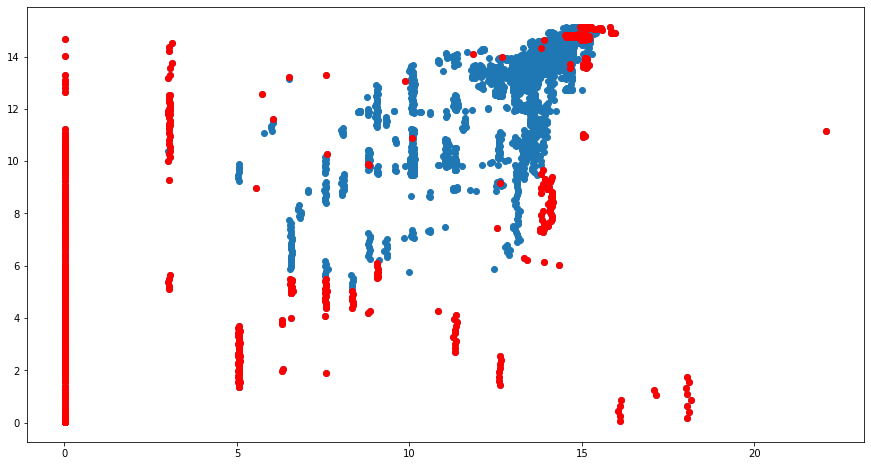

In [17]:
outlier_predicted = df_data_agg.iloc[np.where(predicted == -1)]
outlier_true = df_data_agg[df_data_agg.label == 0]
plt.scatter(df_data_agg['J-0'], df_data_agg['mean'])
plt.scatter(outlier_predicted['J-0'], outlier_predicted['mean'], c='r')
plt.show()

In [18]:
def plot_outliers(data_df, true_labels, clf, labels={'normal': 1, 'anomaly': -1}):
    # xx, yy = np.meshgrid(np.arange(0, 20, .1),
    #                      np.arange(0, 20, .1))
    # Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)
    # plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    predictions = clf.predict(data_df)
    outlier_predicted = data_df.iloc[np.where(predictions == labels['anomaly'])]
    outlier_true = data_df[true_labels == labels['anomaly']]
    plt.scatter(data_df['J-0'], data_df['mean'])
    plt.scatter(outlier_true['J-0'], outlier_true['mean'], marker='o', edgecolors='black', facecolors='none')
    plt.scatter(outlier_predicted['J-0'], outlier_predicted['mean'], marker='x', c='r')
    plt.show()

In [23]:
from sklearn.svm import SVC

svc = SVC(C=20, gamma='auto', kernel='poly', class_weight=y_train.value_counts(normalize=True).to_dict())
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
print('Accuracy', accuracy_score(y_test, svc_predicted))
print('Recall:', recall_score(y_test, svc_predicted, average='macro'))
print('Precision:', precision_score(y_test, svc_predicted, average='macro'))
print('F1-score:', f1_score(y_test, svc_predicted, average='macro'))


Accuracy 0.997671530580565
Recall: 0.9807745059753366
Precision: 0.9920645993531831
F1-score: 0.9863472114783456


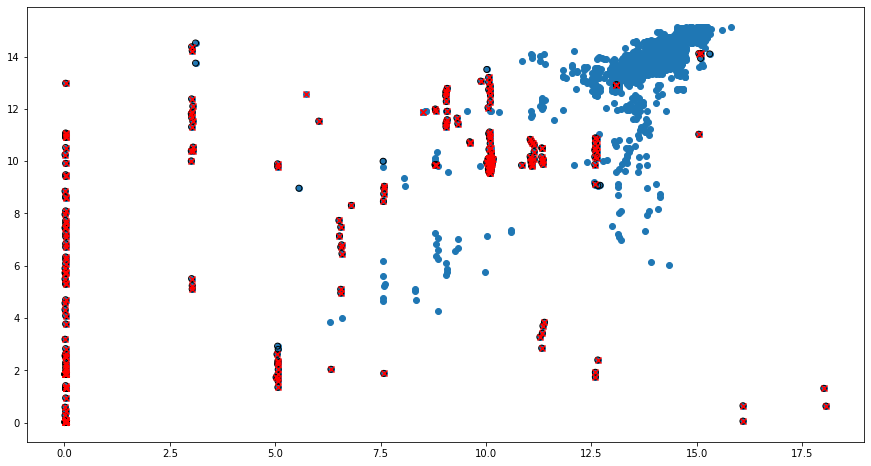

In [20]:
plot_outliers(X_test, y_test, svc, {'normal': 1, 'anomaly': 0})

In [22]:
pd.Series(svc_predicted).value_counts(), y_test.value_counts()

(1.0    6158
 0.0     284
 dtype: int64,
 1.0    6151
 0.0     291
 Name: label, dtype: int64)

In [60]:
def train_test_sensor(n_sensor: str, plotting = False, sensor_df=sensor_data):
    df = pd.DataFrame(sensor_df, columns=['Operation', n_sensor]).dropna()
    print('======== Concatenation started ==========')
    df_agg = pd.concat(data_generator(window_size=800, df=df, sensor_name=n_sensor), axis=0)
    print('======== Concatenation finished ==========')
    df_agg = df_agg.reset_index().drop(['index', 'count'], axis=1)

    labels = df_agg.label
    X_train, X_test, y_train, y_test = train_test_split(df_agg.drop('label', axis=1), labels, test_size=0.3, shuffle=True, stratify=labels)
    clf = SVC(C=20, gamma='auto', kernel='poly', class_weight=y_train.value_counts(normalize=True).to_dict())
    clf.fit(X_train, y_train)

    if plotting:
        plot_outliers(X_test, y_test, clf, {'normal': 1, 'anomaly': 0})

    clf_predicted = clf.predict(X_test)

    return {
        'sensor': n_sensor,
        'accuracy': accuracy_score(y_test, clf_predicted),
        'recall': recall_score(y_test, clf_predicted, average='macro'),
        'precision': precision_score(y_test, clf_predicted, average='macro'),
        'f1_score': f1_score(y_test, clf_predicted, average='macro')
    }


In [67]:
from multiprocessing import Pool
from functools import partial

worker_func = partial(train_test_sensor, sensor_df = sensor_data)

with Pool() as pool:
    metrics_sensors = pool.map(worker_func, [sensor_name for sensor_name in sensor_data.columns])

======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation finished ==========
======== Concatenation started ==========
======== Concatenation finished ==========
======== Concatenation finished ==========
======== Concatenation finished ==========
======== Concatenation finished ==========
======== Concatenation finished ==========
======== Concatenation finished ==========
======== Concatenation finished ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation started ==========
======== Concatenation finished ==========
======== Concatenation finished ==========
======== Concatenation started ==========
======== Concatenation s

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(metrics_sensors).set_index('sensor')

,accuracy,recall,precision,f1_score
sensor,,,,
sensor_00,0.985510,0.651082,0.980288,0.727097
sensor_01,0.978707,0.839780,0.987242,0.898474
